Similar to Dec 5 work -- but this time will use longer AOM initilization pulses since that could be the cause of the low contrast. Even though I'm working at 1 mW, the high density of NV centers means I could still not be fully initialized to the |0> state. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [4]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM, PulseBlasterArb
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

In [5]:
import pickle
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [6]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)
    
def plot_frequency(scan_data,  experiment, freq = 2870e6):
    frequencies = np.array([x[0] for x  in scan_data ])
    #res_index = np.where(np.isclose(frequencies,freq))
    idx = (np.abs(frequencies - freq)).argmin()
    scan = scan_data[idx]
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])

In [7]:
logging.basicConfig(level=logging.WARNING)
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)
datasources.daqsamplers.logger.setLevel(logging.INFO)

In [8]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [9]:
#first, isolate an NV orientation 
cwodmr_pulser = PulseBlasterCWODMR(pb_board_number=0, clock_period = 100e-9)

In [10]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [11]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-20)

In [98]:
cwodmr_pulser.rf_pulse_duration = 10e-6

In [99]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2765000000.0,
 'freq_high': 2780000000.0,
 'freq_step': 500000.0,
 'rf_power': -20,
 'pulser': {'rf_pulse_duration': 1e-05, 'clock_period': 1e-07}}

In [100]:
cwodmr_exp.freq_low = 2730e6
cwodmr_exp.freq_high = 3030e6
cwodmr_exp.freq_step = 2e6
cwodmr_exp.rf_power = -10

In [111]:
#pulled this up from below --
def contrast_calculator(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    rf_on = trace[len(trace)//8:len(trace)//2]
    rf_off = trace[5*len(trace)//8:]
    return np.sum(rf_on)/np.sum(rf_off)


In [112]:
scan_data = {'data':cwodmr_exp.run(N_cycles=40000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2730000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2732000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2734000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2736000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2738000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2740000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2742000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2744000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2746000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2748000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2750000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2752000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2754000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27600000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2992000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2994000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2996000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2998000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3000000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3002000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3004000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3006000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3008000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3010000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3012000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3014000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3016000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3018000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3020000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 30220000

<IPython.core.display.Javascript object>


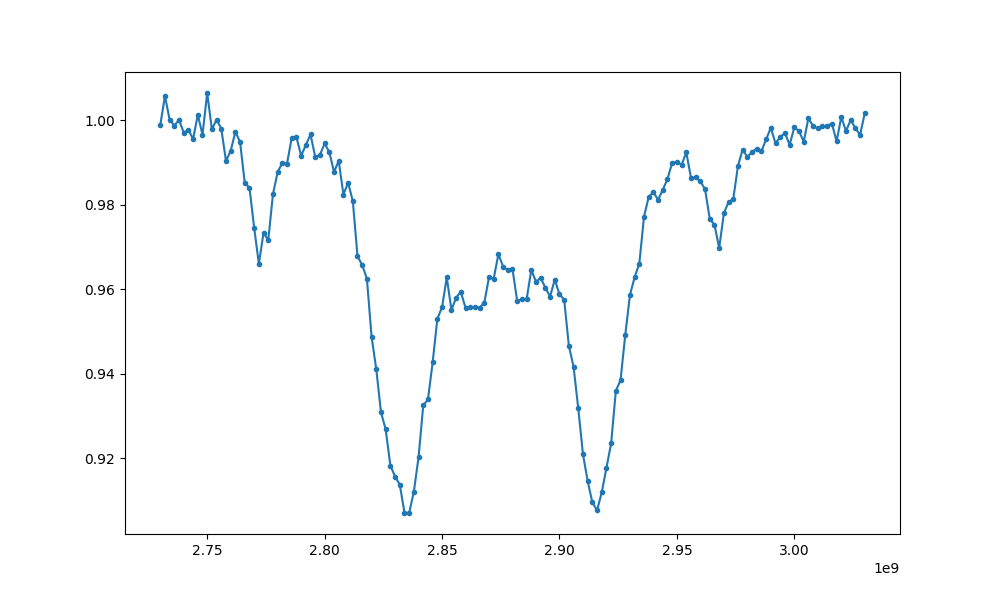

In [113]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [114]:
cwodmr_exp.freq_low = 2755e6
cwodmr_exp.freq_high = 2790e6
cwodmr_exp.freq_step = 1e6
cwodmr_exp.rf_power = -15
scan_data = {'data':cwodmr_exp.run(N_cycles=50000, post_process_function=contrast_calculator), 
             'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2755000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2762000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2763000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2764000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27700000

<IPython.core.display.Javascript object>


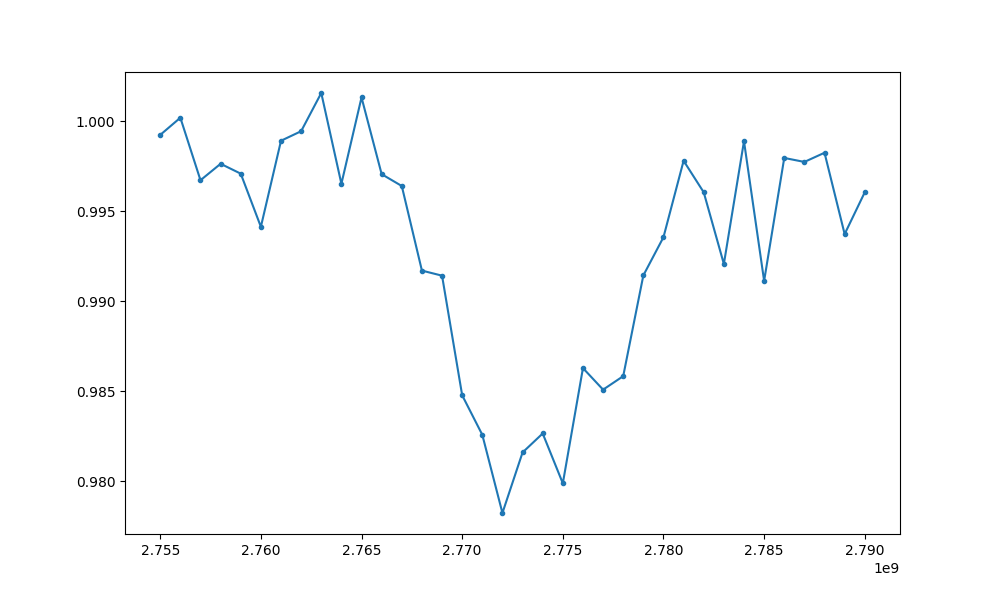

In [115]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [46]:
raw_trace_data = cwodmr_exp.run(N_cycles=200000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2730000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2732000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2734000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2736000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2738000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2740000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2742000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2744000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2746000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2748000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2750000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2752000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2754000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27600000

<IPython.core.display.Javascript object>


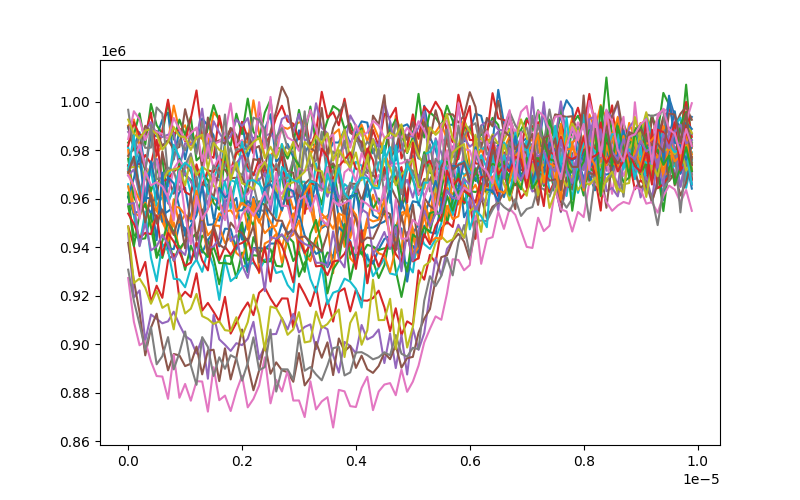

In [47]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in raw_trace_data[::2]:
    
    plot_trace(scan[1], cwodmr_exp.N_cycles, clock_rate = 1./cwodmr_exp.pulser.clock_period, label = scan[0])

<IPython.core.display.Javascript object>


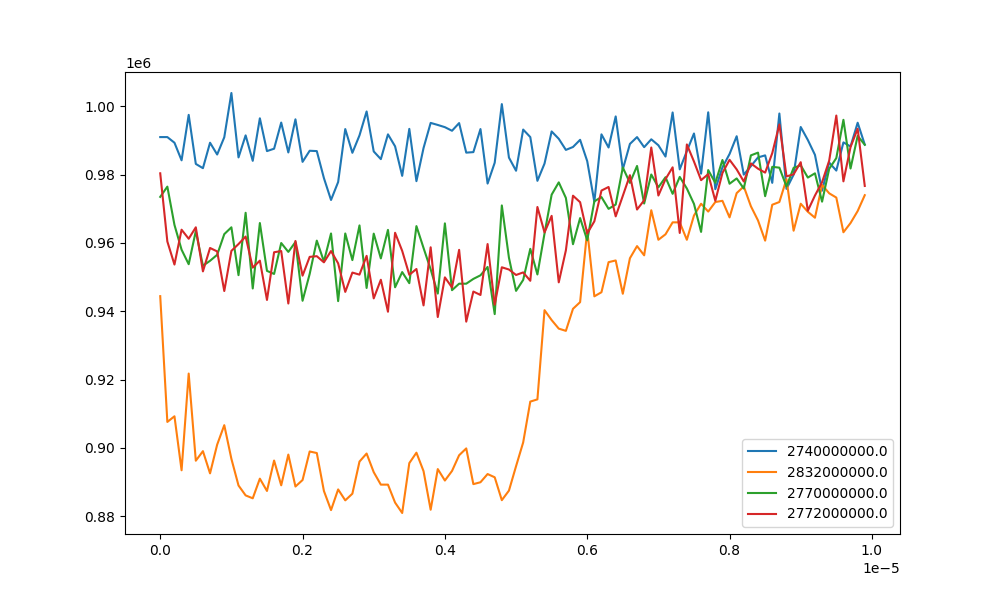

In [48]:
fig, ax = plt.subplots(figsize=(10,6))

# off resonance
plot_frequency(raw_trace_data, cwodmr_exp, 2740e6)
plot_frequency(raw_trace_data, cwodmr_exp, 2832e6)

# on resonance
plot_frequency(raw_trace_data, cwodmr_exp, 2770e6)
plot_frequency(raw_trace_data, cwodmr_exp, 2773e6)

plt.legend()

## Timing issue

The RF switch response time seems to be causing an issue. This can be solved with post-DAQ software (see the contrast_calculator below) or with improved pulse blaster timing.

In [50]:
def contrast_calculator(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    rf_on = trace[len(trace)//4:len(trace)//2]
    rf_off = trace[3*len(trace)//4:]
    return np.sum(rf_on)/np.sum(rf_off)


In [51]:
#narrowing on far left -1 peak

In [52]:
cwodmr_exp.freq_low = 2755e6
cwodmr_exp.freq_high = 2790e6
cwodmr_exp.freq_step = 1e6
cwodmr_exp.rf_power = -10

In [53]:
scan_data_pos2 = {'data':cwodmr_exp.run(N_cycles=40000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2755000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2762000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2763000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2764000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27700000

<IPython.core.display.Javascript object>


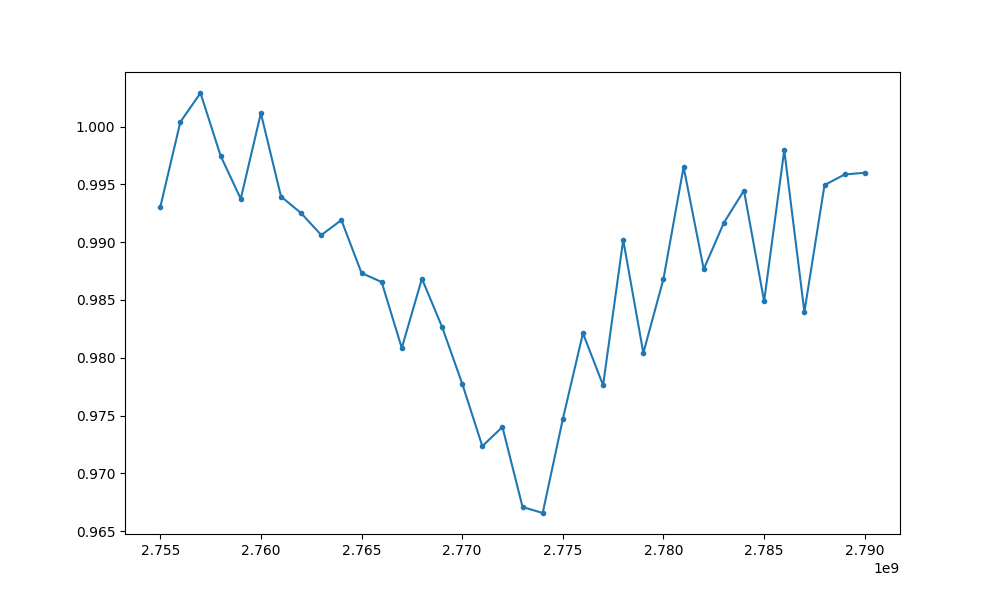

In [54]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_pos2['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [55]:
#decreasing power
cwodmr_exp.freq_step = 1e6
cwodmr_exp.rf_power = -20

In [56]:
scan_data_single_orientation = {'data':cwodmr_exp.run(N_cycles=80000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2755000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2762000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2763000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2764000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27700000

<IPython.core.display.Javascript object>


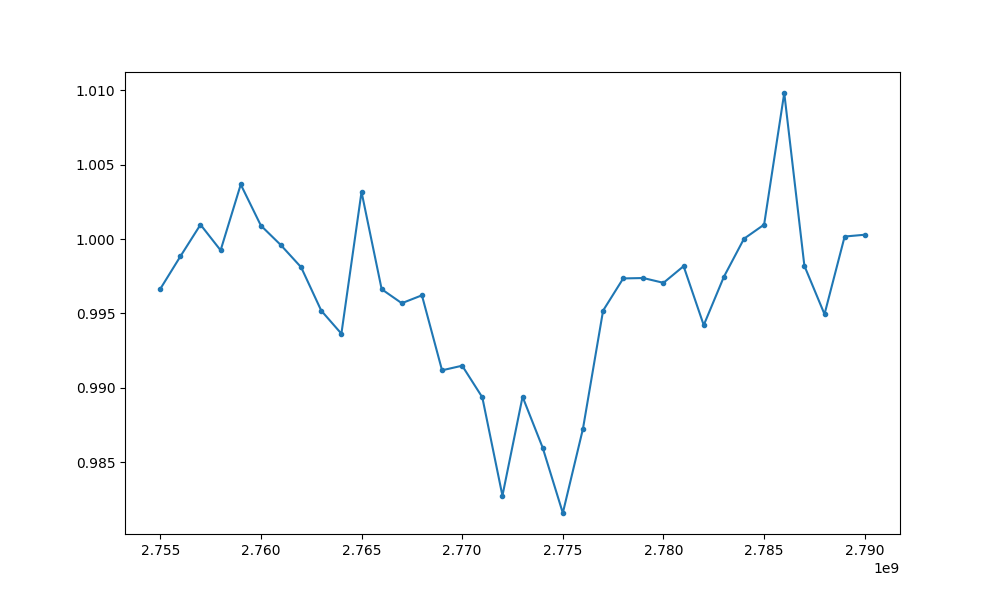

In [57]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [58]:
#decreasing power
cwodmr_exp.freq_step = .5e6
cwodmr_exp.rf_power = -25

In [59]:
scan_data_single_orientation_m25 = {'data':cwodmr_exp.run(N_cycles=80000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2755000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2755500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2762000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27625000

<IPython.core.display.Javascript object>


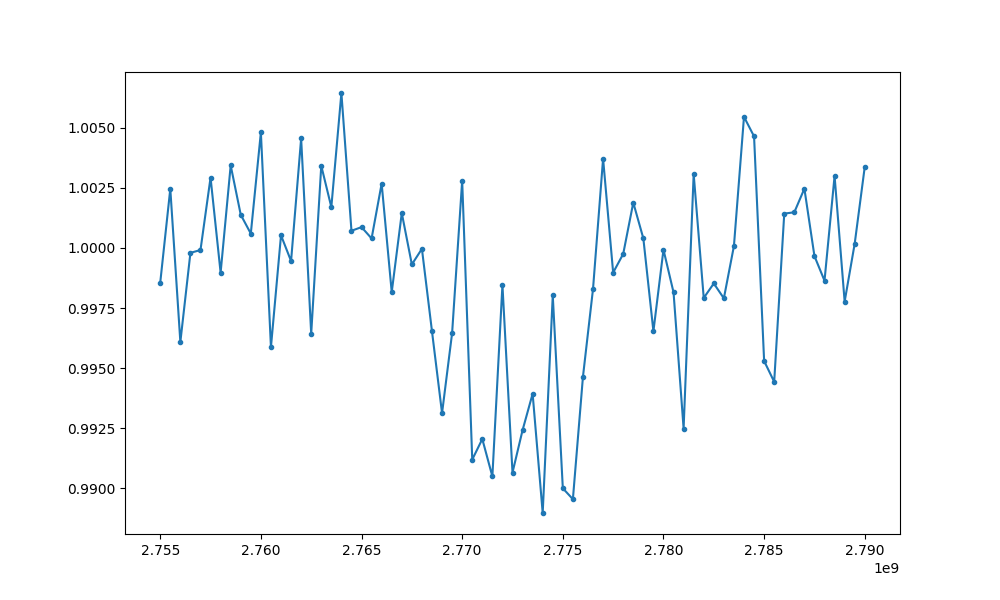

In [60]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m25['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [61]:
scan_data_single_orientation_m25 = {'data':cwodmr_exp.run(N_cycles=200000, post_process_function=contrast_calculator), 'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2755000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2755500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2757500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2759500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2760500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2761500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2762000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27625000

<IPython.core.display.Javascript object>


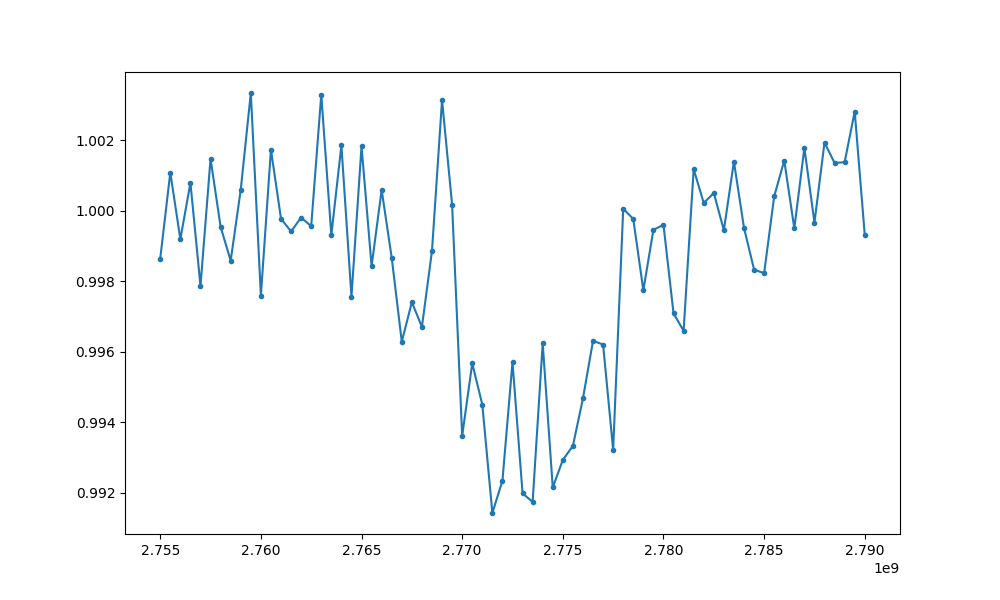

In [62]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m25['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [ ]:
#Increase our pulse durations -- 10 microseconds on/off. We should pump more to |0>

In [95]:
cwodmr_pulser.rf_pulse_duration = 10e-6
cwodmr_exp.freq_low = 2765e6
cwodmr_exp.freq_high = 2780e6

In [96]:
scan_data_single_orientation_m25_10us = {'data':cwodmr_exp.run(N_cycles=200000, post_process_function=contrast_calculator), 
                                    'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765500000.0 Hz


<IPython.core.display.Javascript object>


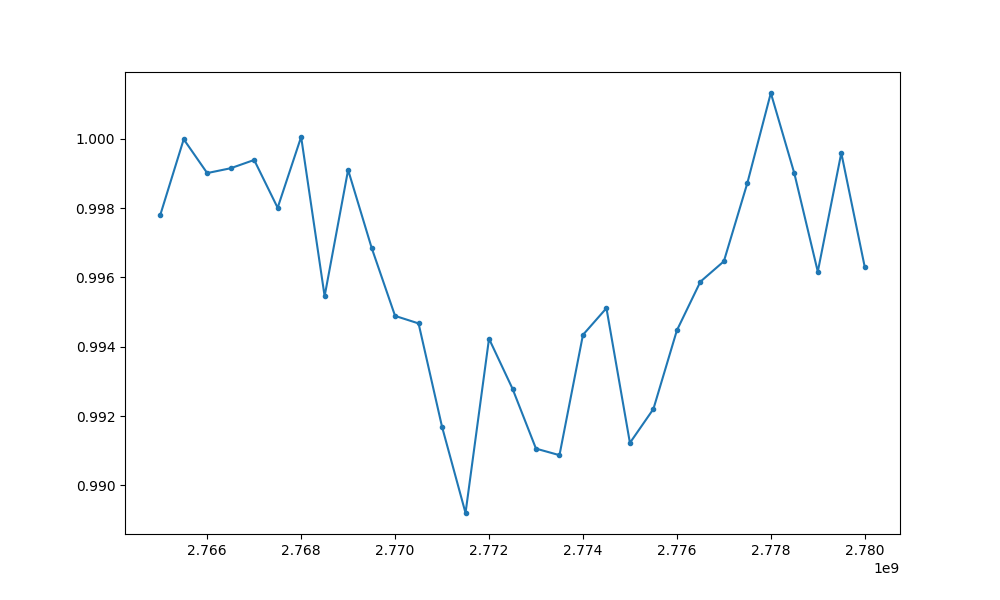

In [65]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m25_10us['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [66]:
cwodmr_exp.rf_power = -10

In [67]:
scan_data_single_orientation_m10_10us = {'data':cwodmr_exp.run(N_cycles=200000, post_process_function=contrast_calculator), 
                                    'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2770000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2770500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2771000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2771500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2772000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27725000

<IPython.core.display.Javascript object>


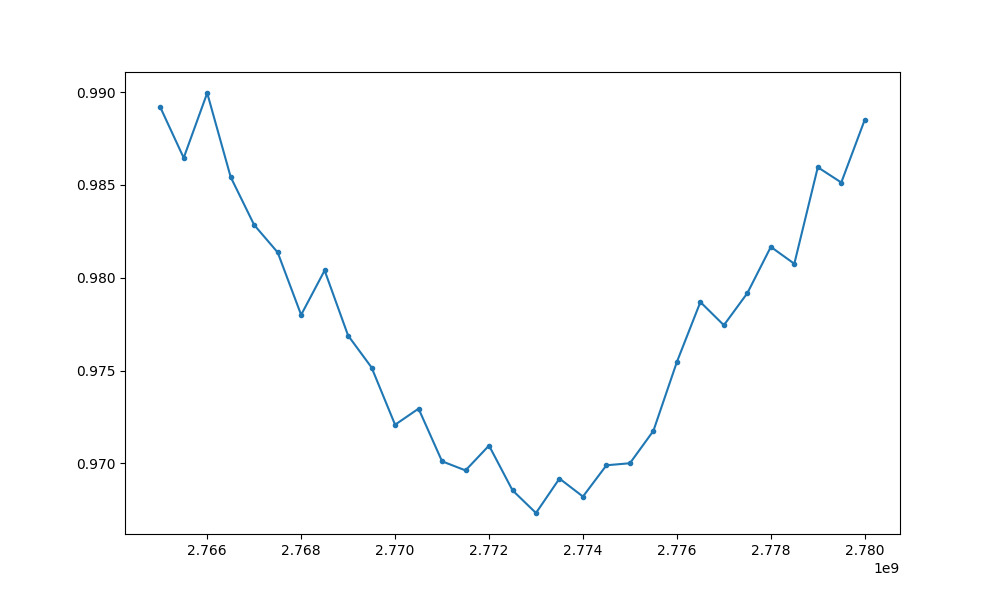

In [68]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m10_10us['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [69]:
cwodmr_exp.rf_power = -20

In [70]:
scan_data_single_orientation_m20_10us = {'data':cwodmr_exp.run(N_cycles=200000, post_process_function=contrast_calculator), 
                                    'conditions':cwodmr_exp.experimental_conditions()}

INFO:qt3utils.experiments.cwodmr:RF frequency: 2765000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2765500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2766500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2767500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2768500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2769500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2770000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2770500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2771000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2771500000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2772000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27725000

<IPython.core.display.Javascript object>


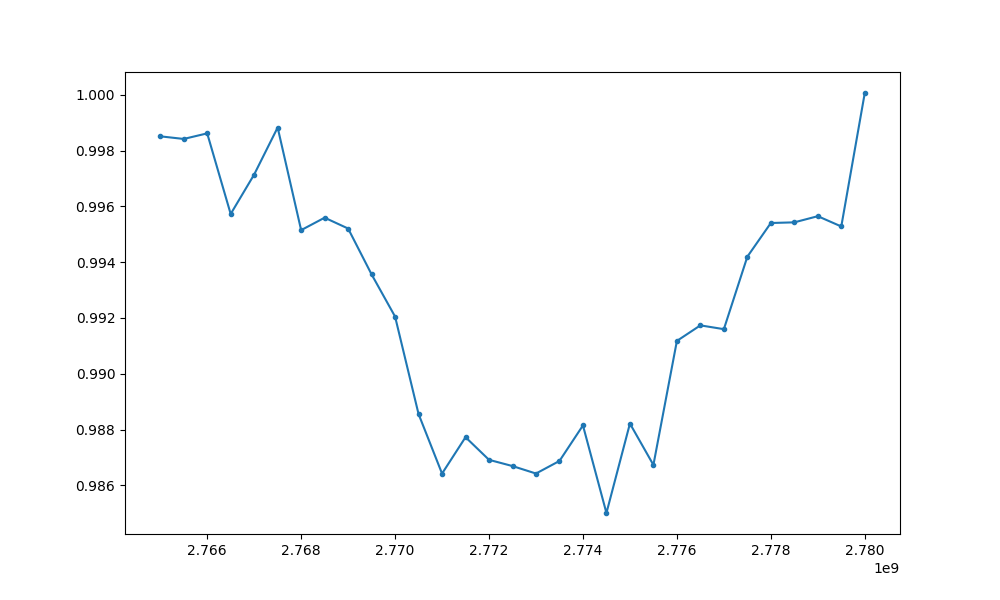

In [71]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data_single_orientation_m20_10us['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [117]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2755000000.0,
 'freq_high': 2790000000.0,
 'freq_step': 1000000.0,
 'rf_power': -15,
 'pulser': {'rf_pulse_duration': 1e-05, 'clock_period': 1e-07}}

<IPython.core.display.Javascript object>


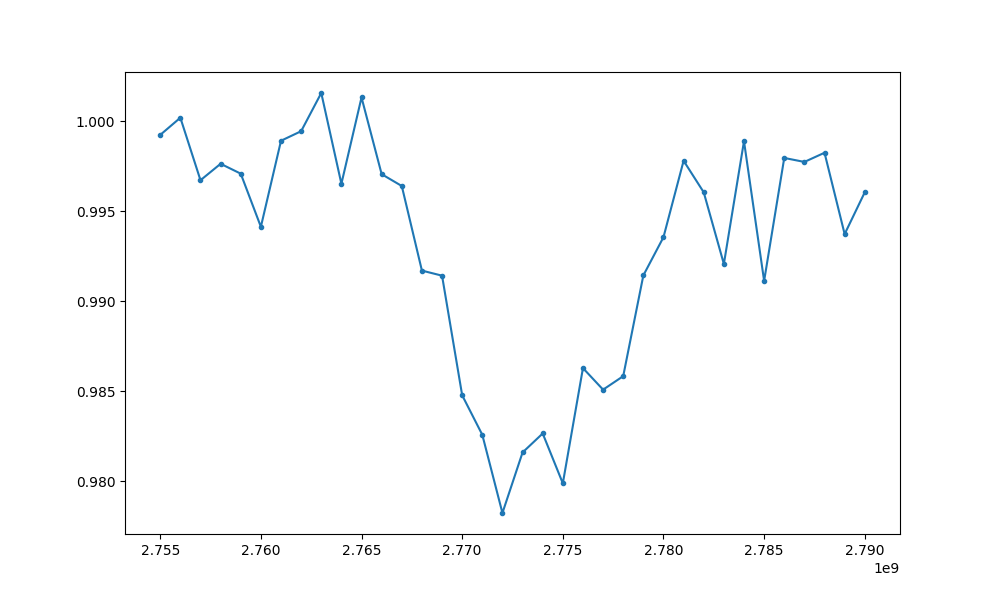

In [118]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [126]:
podmr_pulser = PulseBlasterPulsedODMR(pb_board_number=0, clock_period = 100e-9,
                                      aom_width=10e-6,
                                      rf_pulse_duration=10e-6, 
                                      rf_response_time=3e-7,
                                     full_cycle_width=45e-6)
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

podmr_exp = qt3utils.experiments.podmr.PulsedODMR(podmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-15, 
                                                  freq_low=cwodmr_exp.freq_low,
                                                  freq_high=cwodmr_exp.freq_high,
                                                  freq_step=1e6)

In [128]:
qt3utils.experiments.podmr.logger.setLevel(logging.INFO)

In [129]:
podmr_exp.experimental_conditions()

{'freq_low': 2755000000.0,
 'freq_high': 2790000000.0,
 'freq_step': 1000000.0,
 'rf_power': -15,
 'pulser': {'rf_pulse_duration': 1e-05,
  'aom_width': 1e-05,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 4.5e-05,
  'rf_pulse_justify': 'center',
  'clock_period': 1e-07}}

In [127]:
podmr_raw_scan = podmr_exp.run(N_cycles=10000, post_process_function=qt3utils.experiments.common.aggregate_sum)

In [88]:
podmr_raw_scan

array([[2765000000.0,
        array([1.000e+01, 1.300e+01, 6.000e+00, 1.000e+01, 3.000e+00, 1.587e+03,
               5.219e+03, 5.117e+03, 5.056e+03, 5.049e+03, 4.901e+03, 5.028e+03,
               5.008e+03, 5.078e+03, 5.091e+03, 5.015e+03, 5.016e+03, 4.977e+03,
               5.040e+03, 5.052e+03, 5.036e+03, 5.035e+03, 5.042e+03, 5.145e+03,
               5.059e+03, 5.100e+03, 5.033e+03, 5.010e+03, 5.068e+03, 5.039e+03,
               4.988e+03, 5.117e+03, 5.039e+03, 5.206e+03, 4.977e+03, 5.045e+03,
               4.980e+03, 5.022e+03, 5.028e+03, 5.152e+03, 5.077e+03, 4.990e+03,
               4.986e+03, 5.112e+03, 5.033e+03, 5.116e+03, 5.135e+03, 5.130e+03,
               5.120e+03, 5.074e+03, 5.086e+03, 5.024e+03, 5.179e+03, 5.268e+03,
               5.104e+03, 5.081e+03, 5.064e+03, 5.012e+03, 5.039e+03, 4.976e+03,
               5.056e+03, 5.057e+03, 5.078e+03, 4.970e+03, 5.128e+03, 4.975e+03,
               5.174e+03, 5.045e+03, 4.993e+03, 5.053e+03, 5.089e+03, 5.032e+03,
      

<IPython.core.display.Javascript object>


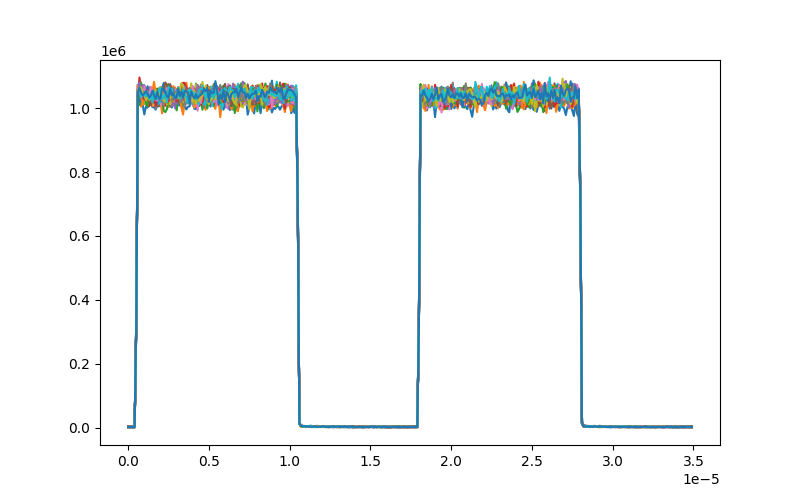

In [89]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in podmr_raw_scan:
    
    plot_trace(scan[1], podmr_exp.N_cycles, clock_rate = 1./podmr_exp.pulser.clock_period, label = scan[0])

In [130]:
def podmr_contrast(data_buffer, experiment):
    trace = qt3utils.experiments.common.aggregate_sum(data_buffer, experiment)
    trace = trace/experiment.N_cycles / experiment.pulser.clock_period
    trace[trace < 1e4] = 0
    background = trace[:len(trace)//2]
    signal = trace[len(trace)//2:]
    return np.sum(signal)/np.sum(background)

In [131]:
#default 
podmr_scan = podmr_exp.run(N_cycles=50000, post_process_function=podmr_contrast)

INFO:qt3utils.experiments.podmr:RF frequency: 2.7550000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7560000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.757 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.758 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7590000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7600000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.761 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.762 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7630000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7640000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.765 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.766 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7670000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.7680000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.769 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.77 GHz
I

<IPython.core.display.Javascript object>


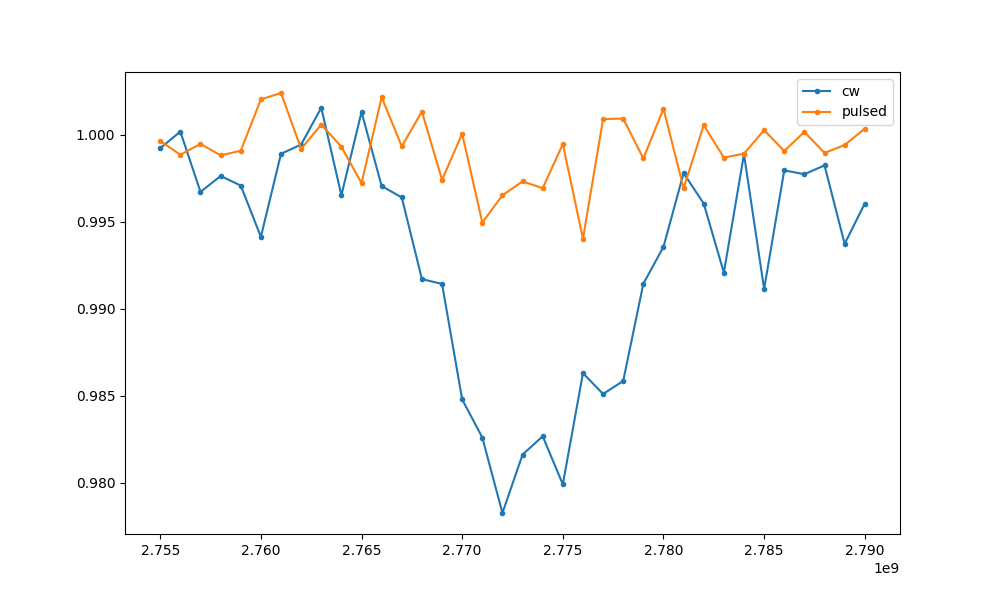

In [132]:
plt.figure(figsize=(10,6))
scan = np.array(scan_data['data'])
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-', label = 'cw')

scan = np.array(podmr_scan)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-', label = 'pulsed')
plt.legend()

In [198]:
resonance_freq = 2932.5e6

In [195]:
qt3utils.experiments.rabi.Rabi?

In [204]:
qt3utils.experiments.rabi.logger.setLevel(logging.INFO)


In [201]:
podmr_pulser = PulseBlasterPulsedODMR(pb_board_number=0, clock_period = 100e-9,
                                      aom_width=3e-6,
                                      rf_pulse_duration=1e-6, 
                                      rf_response_time=3e-7,
                                     full_cycle_width=30e-6)

rabi_exp = qt3utils.experiments.rabi.Rabi(podmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-25,rf_frequency=resonance_freq)

In [203]:
rabi_exp.experimental_conditions()

{'rf_pulse_duration_low': 1e-07,
 'rf_pulse_duration_high': 1e-05,
 'rf_pulse_duration_step': 5e-08,
 'rf_power': -25,
 'rf_frequency': 2932500000.0,
 'pulser': {'rf_pulse_duration': 2.65e-06,
  'aom_width': 3e-06,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 3e-05,
  'rf_pulse_justify': 'center',
  'clock_period': 1e-07}}

In [205]:
rabi_raw_scan = rabi_exp.run(N_cycles=2000, post_process_function=qt3utils.experiments.common.aggregate_sum)

INFO:qt3utils.experiments.rabi:RF Width: 1e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9.5e-07 

INFO:qt3utils.experiments.rabi:RF Width: 7.3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.35e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.45e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.55e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.65e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.7e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.75e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.85e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.9e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.95e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.05e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.1e-06 seconds
INFO:qt3utils.experiments

<IPython.core.display.Javascript object>


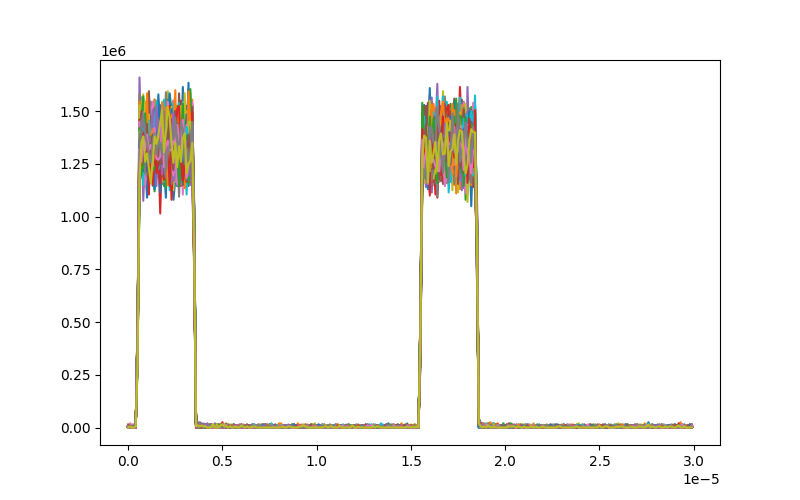

In [206]:
fig, ax = plt.subplots(figsize=(8,5))

for scan in rabi_raw_scan:
    
    plot_trace(scan[1], rabi_exp.N_cycles, clock_rate = 1./rabi_exp.pulser.clock_period, label = scan[0])

In [215]:
rabi_exp.rf_pulse_duration_high = 5e-6
rabi_exp.rf_pulse_duration_step = 100e-9

In [216]:
rabi_scan = rabi_exp.run(N_cycles=200000, post_process_function=podmr_contrast)

INFO:qt3utils.experiments.rabi:RF Width: 1e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.7e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.8e-06 se

<IPython.core.display.Javascript object>


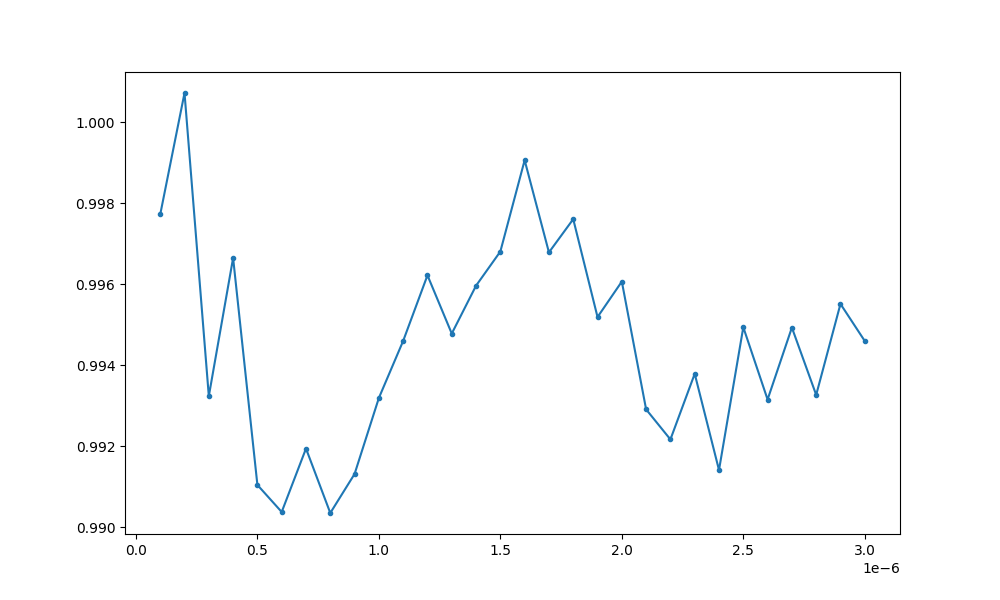

In [217]:
plt.figure(figsize=(10,6))
scan = np.array(rabi_scan)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')

In [224]:
podmr_exp.pulser.rf_pulse_duration = 0.75e-6
podmr_exp.freq_step = 0.1e6
podmr_exp.freq_low = 2928e6
podmr_exp.freq_high = 2938e6


In [227]:
podmr_scan = podmr_exp.run(N_cycles=500000, post_process_function=podmr_contrast)

INFO:qt3utils.experiments.podmr:RF frequency: 2.9280000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9281 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9282000000000004 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9283 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9284000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9285 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9286000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9287 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9288000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9289 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9290000000000003 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9291 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9292000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9293 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9294000000000002 GHz
INFO:qt3utils.experiments.podmr:RF frequency: 2.9

<IPython.core.display.Javascript object>


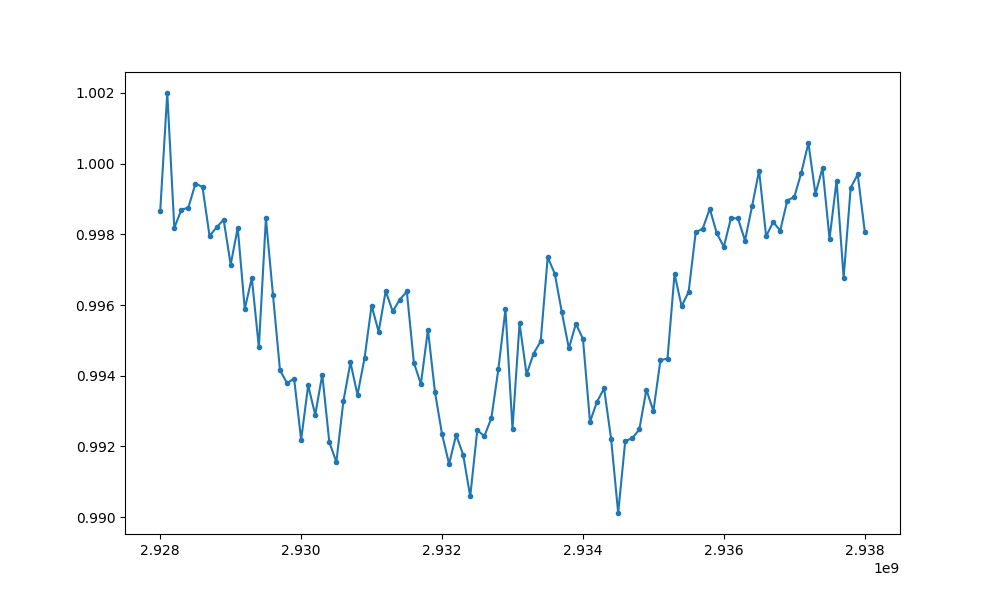

In [228]:
plt.figure(figsize=(10,6))
scan = np.array(podmr_scan)
x_data = scan[:, 0]
y_data = scan[:, 1]
plt.plot(x_data, y_data, '.-')